# **Predicting Chances of Admission**

--------------------
## **Context**
--------------------

The world is developing rapidly and continuously looking for the best knowledge and experience among people. This motivates people all around the world to stand out in their jobs and look for higher degrees that can help them in improving their skills and knowledge. As a result, the number of students applying for Master's programs has increased substantially.

The current admission dataset was created for the prediction of admissions into the University of California, Los Angeles (UCLA). It was built to help students in shortlisting universities based on their profiles. The predicted output gives them a fair idea about their chances of getting accepted.

----------------------
## **Objective**
----------------------

We need to build a classification model using neural networks to predict a student's chances of admission into UCLA.

------------------------------
## **Data Dictionary**
------------------------------

The dataset contains several features which are considered important during the application for Masters Programs.
The features included are: 

- **GRE Scores:** (out of 340)

- **TOEFL Scores:** (out of 120)

- **University Rating:**  It indicates the Bachelor University ranking (out of 5)

- **Statement of Purpose Strength:** (out of 5)

- **Letter of Recommendation Strength:** (out of 5)

- **Undergraduate GPA:** (out of 10)

- **Research Experience:** (either 0 or 1)

- **Chance of Admit:** (ranging from 0 to 1)

## **Import Library**

In [53]:
import pandas as pd 
import numpy as np 
import random

import seaborn as sns 
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf 
from tensorflow.keras.models import Sequential 
from tensorflow.keras import backend
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization

import warnings
warnings.filterwarnings('ignore')

## **Import Data**

In [2]:
data = pd.read_csv('Admission_Predict_Ver1.csv')
data.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Serial No.         500 non-null    int64  
 1   GRE Score          500 non-null    int64  
 2   TOEFL Score        500 non-null    int64  
 3   University Rating  500 non-null    int64  
 4   SOP                500 non-null    float64
 5   LOR                500 non-null    float64
 6   CGPA               500 non-null    float64
 7   Research           500 non-null    int64  
 8   Chance of Admit    500 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 35.3 KB


In [4]:
data.isnull().sum()

Serial No.           0
GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64

In [5]:
data.duplicated().sum()

0

- The dataset has 500 data points with 8 features. 
- All the data are in numerical format. 
- The dataset has no missing values or duplicates. 

In [6]:
data['Serial No.'].nunique()

500

- All the serial numbers are unique and doesn't add to the model so we can drop this column. 

In [7]:
data.drop('Serial No.', axis=1, inplace=True)
data.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65


## **Exploratory Data Analysis**

In [8]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
GRE Score,500.0,316.47200,11.295148,290.00,308.0000,317.00,325.00,340.00
TOEFL Score,500.0,107.19200,6.081868,92.00,103.0000,107.00,112.00,120.00
University Rating,500.0,3.11400,1.143512,1.00,2.0000,3.00,4.00,5.00
SOP,500.0,3.37400,0.991004,1.00,2.5000,3.50,4.00,5.00
LOR,500.0,3.48400,0.925450,1.00,3.0000,3.50,4.00,5.00
CGPA,500.0,8.57644,0.604813,6.80,8.1275,8.56,9.04,9.92
Research,500.0,0.56000,0.496884,0.00,0.0000,1.00,1.00,1.00
Chance of Admit,500.0,0.72174,0.141140,0.34,0.6300,0.72,0.82,0.97


- The average GRE score of students applying for UCLA is 316.5 out of 340 with min of 290 and max of 340. 
- The average TOFEL score of students applying for UCLA is ~107 out of 120 with min of 92 and max of 120. 
- The average undergrad university ranking of students applying for UCLA is ~3 out of 5 with min of 1 and max of 5. 
- Students applying for UCLA has a wide SOP from ranking of 1 to 5. 
- Students applying for UCLA has a wide LOR from ranking of 1 to 5.
- The average CGPA score of students applying for UCLA is ~8.57 out of 10 with min of 6.8 and max of 9.92. 
- 56% of students applying for UCLA have research experience. 
- On average the chance of admission is 72% with min of 34% and max of 97%. Of course all of these are not getting admitted so we need to define a threshold here. 

#### **Univariate Data Analysis**

In [9]:
def box_hist_plot(data, feature):
    fig, (ax_box, ax_hist) = plt.subplots(nrows=2, ncols=1, 
                                          figsize= (10,5), sharex=True ,
                                          gridspec_kw={'height_ratios':(0.25, 0.75)})
    sns.boxplot(data=data, x=feature, showmeans=True, ax=ax_box, color= 'violet')
    sns.histplot(data=data, x=feature, kde=True, ax=ax_hist)
    ax_hist.axvline(data[feature].mean(), color='green', linestyle= '--')
    ax_hist.axvline(data[feature].median(), color='black', linestyle= '-')
    

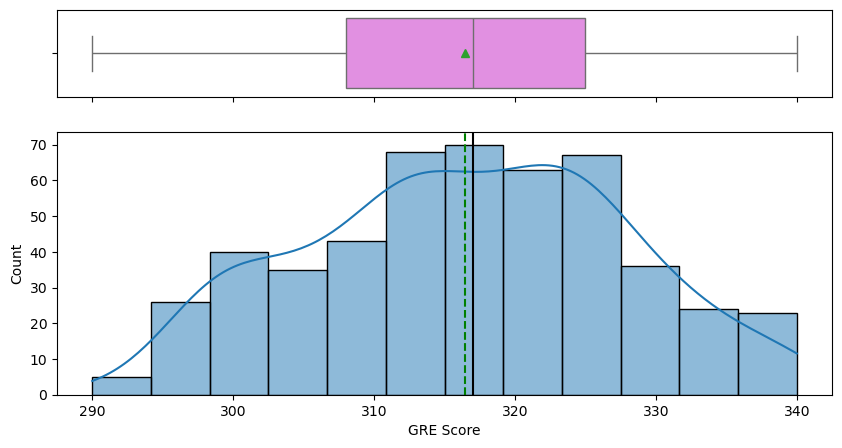

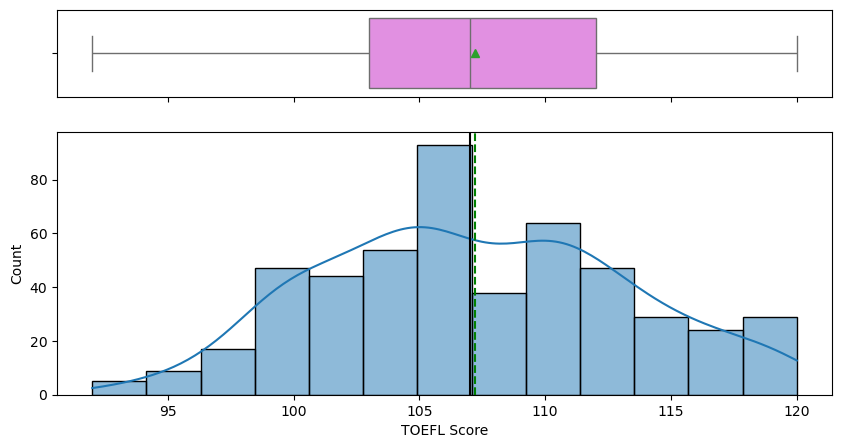

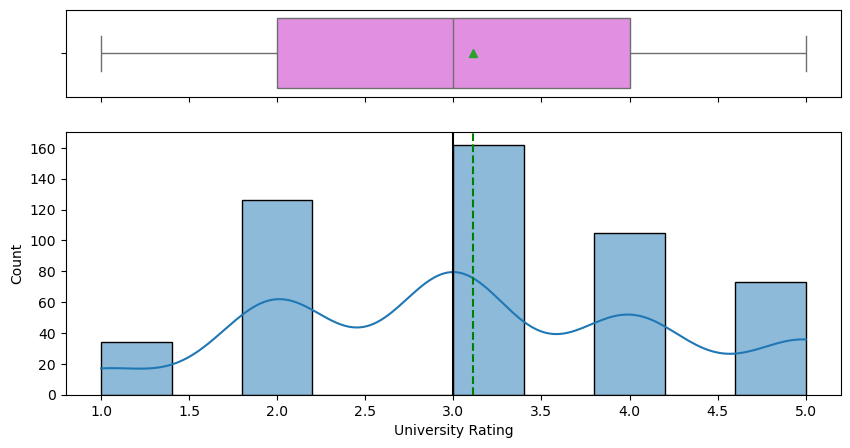

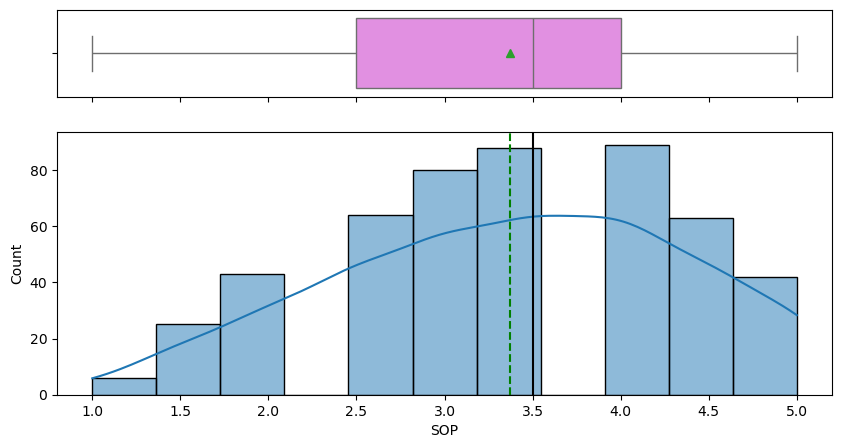

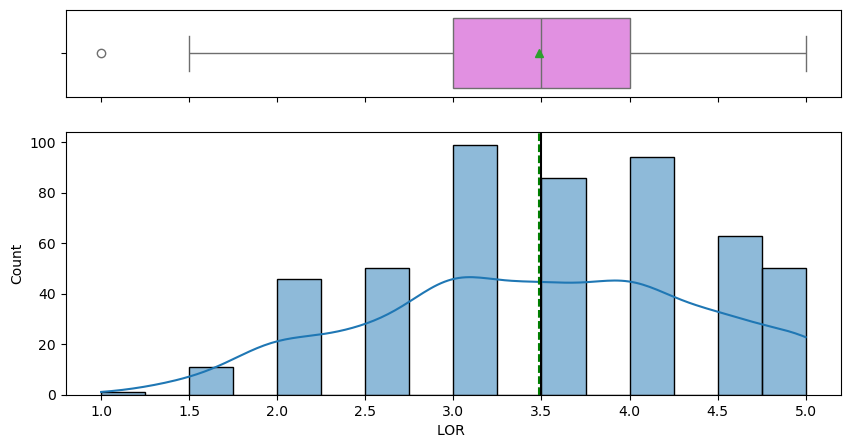

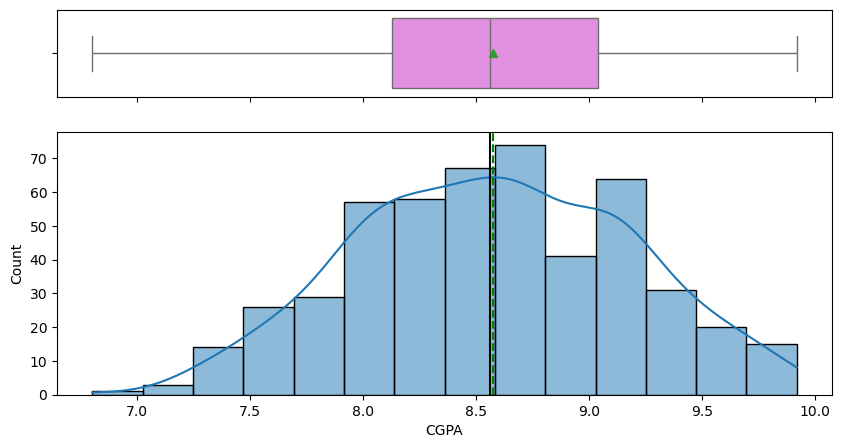

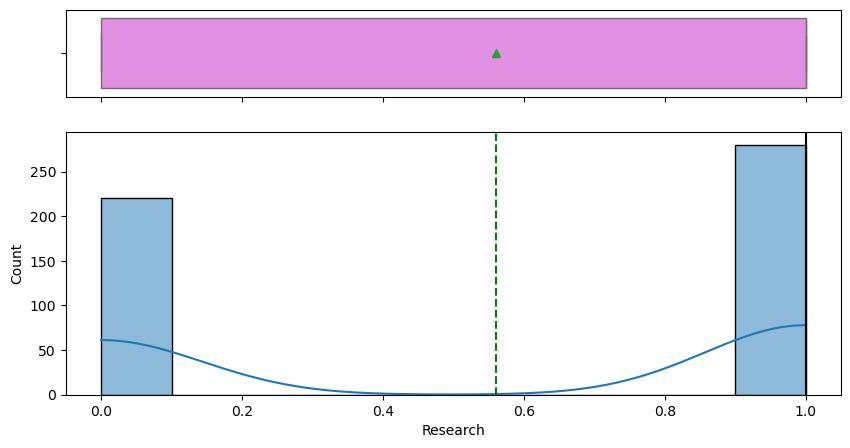

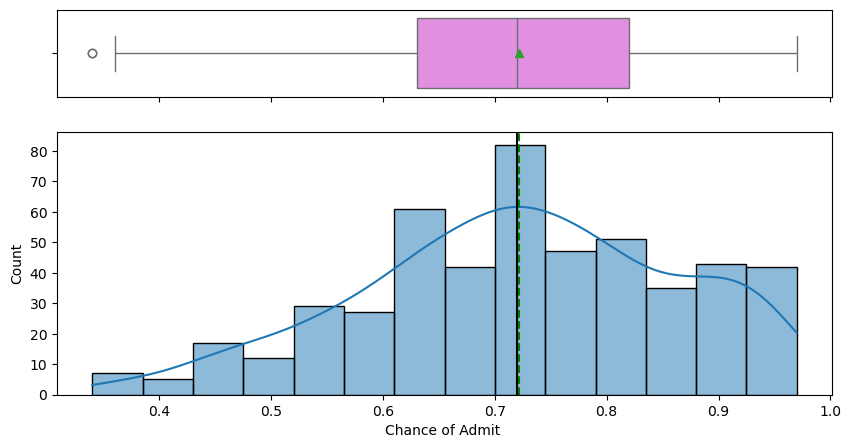

In [10]:
num_feature = data.select_dtypes(include=('float', 'int')).columns.to_list()

for col in num_feature: 
    box_hist_plot(data, col)

In [11]:
(data['Chance of Admit '] > 0.8).sum()

142

- Let's assume that university doesn't accept more than ~140 students then the cut of for chance of admission is going to be 80%. So we are going to create a binary cloumn with 1 getting admitted and 0 not getting admitted. 

In [12]:
data['Admit'] = data['Chance of Admit '].apply(lambda x: 1 if x>0.8 else 0)

In [13]:
data['Admit'].value_counts()

Admit
0    358
1    142
Name: count, dtype: int64

Removing chance of admit column: 

In [14]:
data.drop('Chance of Admit ', axis=1, inplace=True)

#### **Bivariate Data Analysis**

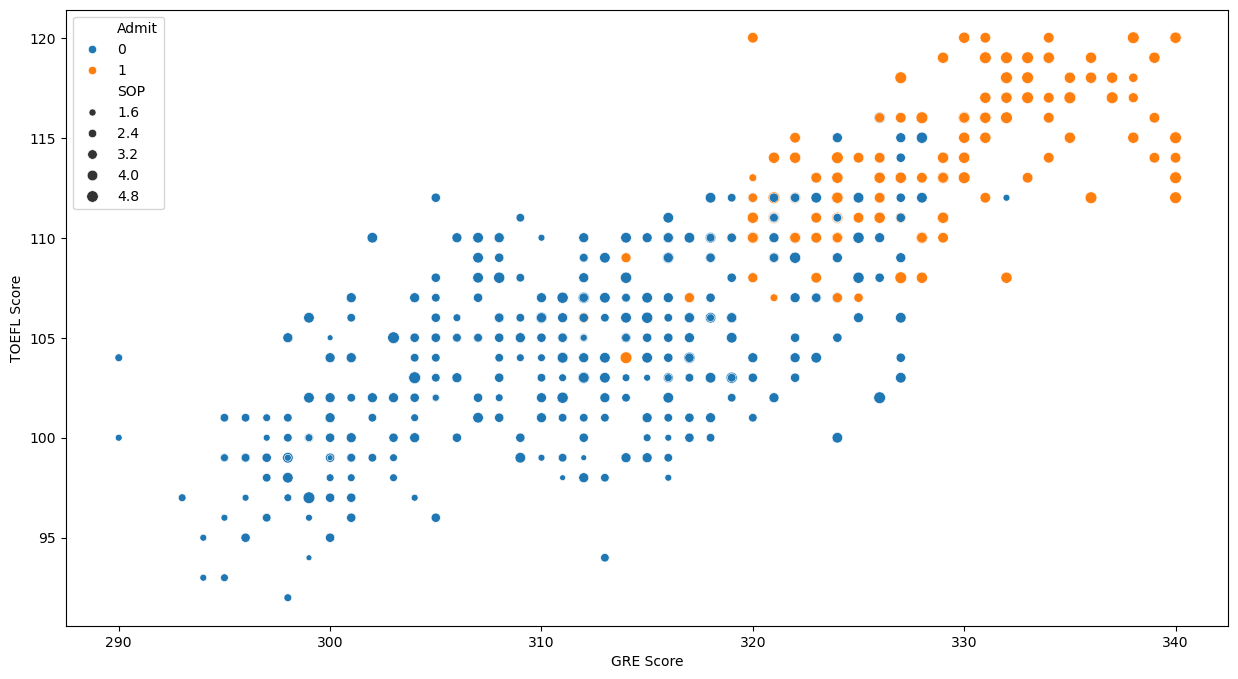

In [15]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=data,
                 x='GRE Score',
                 y='TOEFL Score', 
                 hue='Admit', 
                 size='SOP');

- As the GRE and TOEFL socre increases the chance of admitting to UCLA increases as well. 
- There is a linear relation between GRE and TOEFL socre which is reasonable. 
- It seems that as the GRE and TOEFL score increases the strength of the SOP also increases. 


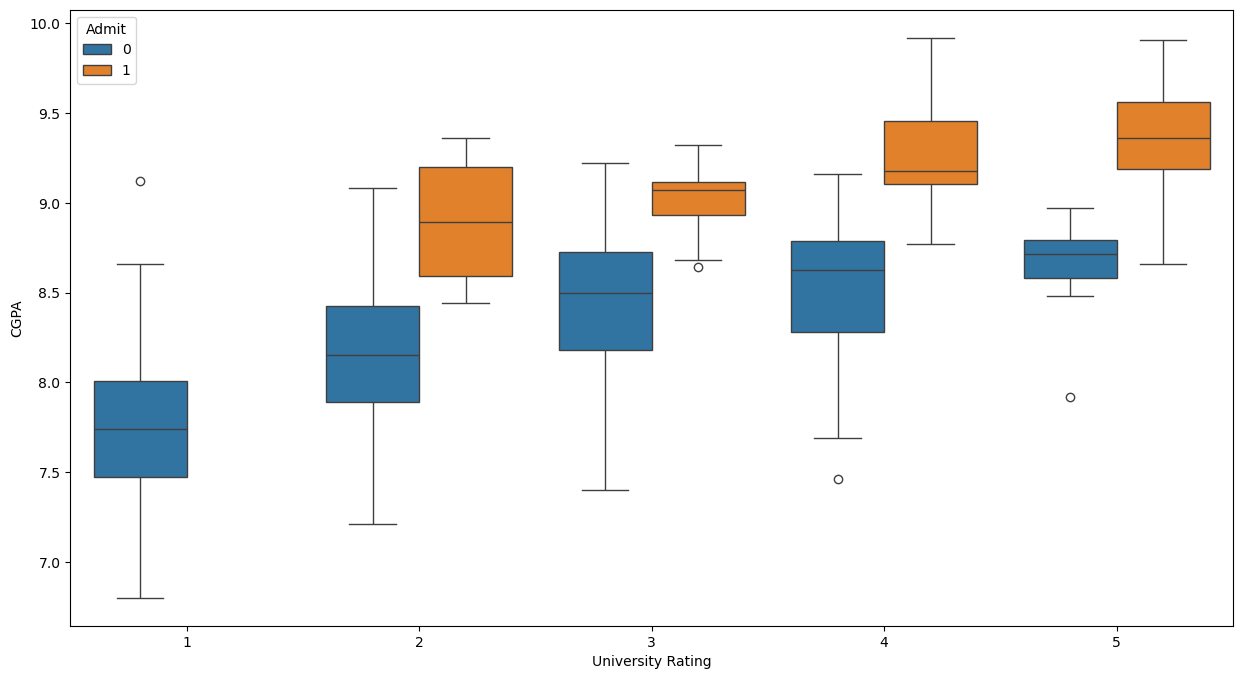

In [16]:
plt.figure(figsize=(15,8))
sns.boxplot(data=data,
                 x='University Rating',
                 y='CGPA', 
                 hue='Admit', 
                 );

- The higher GPA have higher chance of admiting to UCLA.
- The higher the ranking of the universities the higher CGPA. 

## **Data Preparation**

- SOP and LOR are having .5 size there so these should stay numerical values. 
- University Ranking is categorical data so let's do onehot enconding for it. 

In [17]:
one_hot_data = pd.concat([data, pd.get_dummies(data['University Rating'], prefix = 'University Rating')], axis=1)
one_hot_data.drop('University Rating', axis=1, inplace=True)
one_hot_data.head()

,GRE Score,TOEFL Score,SOP,LOR,CGPA,Research,Admit,University Rating_1,University Rating_2,University Rating_3,University Rating_4,University Rating_5
0,337,118,4.5,4.5,9.65,1,1,False,False,False,True,False
1,324,107,4.0,4.5,8.87,1,0,False,False,False,True,False
2,316,104,3.0,3.5,8.00,1,0,False,False,True,False,False
3,322,110,3.5,2.5,8.67,1,0,False,False,True,False,False
4,314,103,2.0,3.0,8.21,0,0,False,True,False,False,False


In [18]:
X = one_hot_data.drop('Admit', axis=1)
Y = one_hot_data['Admit']

In [19]:
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

In [20]:
y_test.value_counts(normalize=True)

Admit
0    0.73
1    0.27
Name: proportion, dtype: float64

In [21]:
y_train.value_counts(normalize=True)

Admit
0    0.7125
1    0.2875
Name: proportion, dtype: float64

In [22]:
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

## **Building Model**

#### **Model 1:**

In [30]:
backend.clear_session()

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [31]:
model1 = Sequential()
model1.add(Dense(128, activation='relu', input_shape=(11,)))
model1.add(Dropout(0.2))
model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.1))
model1.add(Dense(1, activation='sigmoid'))

model1.compile(loss='binary_crossentropy', optimizer='adamax' ,metrics=['accuracy'])


In [32]:
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,857 (38.50 KB)

 Trainable params: 9,857 (38.50 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
hist_model1 = model1.fit(x_train_scaled, y_train,
 validation_split=0.1, epochs=150, verbose=1)

Epoch 1/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6161 - loss: 0.6726 - val_accuracy: 0.5750 - val_loss: 0.6368
Epoch 2/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7388 - loss: 0.5925 - val_accuracy: 0.5750 - val_loss: 0.5998
Epoch 3/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7351 - loss: 0.5470 - val_accuracy: 0.7250 - val_loss: 0.5482
Epoch 4/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8066 - loss: 0.4952 - val_accuracy: 0.8250 - val_loss: 0.4927
Epoch 5/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8608 - loss: 0.4555 - val_accuracy: 0.9000 - val_loss: 0.4428
Epoch 6/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8453 - loss: 0.4307 - val_accuracy: 0.9250 - val_loss: 0.3984
Epoch 7/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8436 - loss: 0.3987 - val_accuracy: 0.9250 - val_loss: 0.3635
Epoch 8/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8630 - loss: 0.3680 - val_accuracy: 0.9250 - 

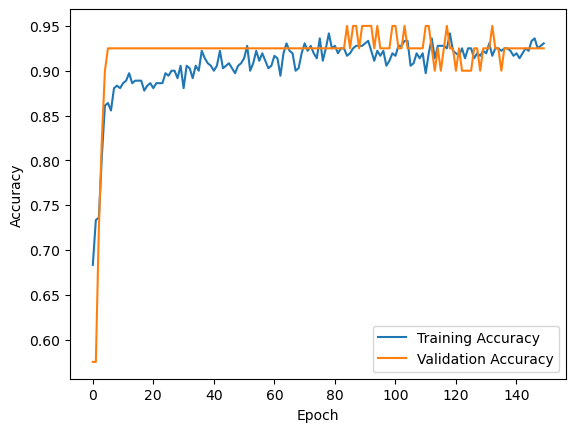

In [35]:
plt.plot(hist_model1.history['accuracy'], label='Training Accuracy')
plt.plot(hist_model1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

- The model accuracy is increasing by incrasing numbers of epochs.
- The validation accuracy almost constant after 20 epochs till 90 and then start fluctuating afterward. 
- The training and validation accuracy is around ~93% meaning that the model is generalizing well. 
- Let's paly with some hyperparameters. 

#### **Model 2:**

In [42]:
backend.clear_session()

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [43]:
model2 = Sequential()
model2.add(Dense(128, activation='tanh', input_shape=(11,)))
model2.add(Dropout(0.1))
model2.add(Dense(64, activation='tanh'))
model2.add(Dropout(0.1))
model2.add(Dense(32, activation='tanh'))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy', optimizer='adam' ,metrics=['accuracy'])
model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,905 (46.50 KB)

 Trainable params: 11,905 (46.50 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
hist_model2 = model2.fit(x_train_scaled, y_train,
 validation_split=0.1, epochs=100, verbose=1)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6178 - loss: 0.6168 - val_accuracy: 0.8250 - val_loss: 0.4867
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8368 - loss: 0.4102 - val_accuracy: 0.9000 - val_loss: 0.3126
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8523 - loss: 0.3500 - val_accuracy: 0.9250 - val_loss: 0.2960
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8525 - loss: 0.3234 - val_accuracy: 0.9000 - val_loss: 0.2783
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8547 - loss: 0.3162 - val_accuracy: 0.9250 - val_loss: 0.2795
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8492 - loss: 0.3020 - val_accuracy: 0.9250 - val_loss: 0.2637
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8687 - loss: 0.2854 - val_accuracy: 0.9250 - val_loss: 0.2574
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8741 - loss: 0.2586 - val_accuracy: 0.9250 - 

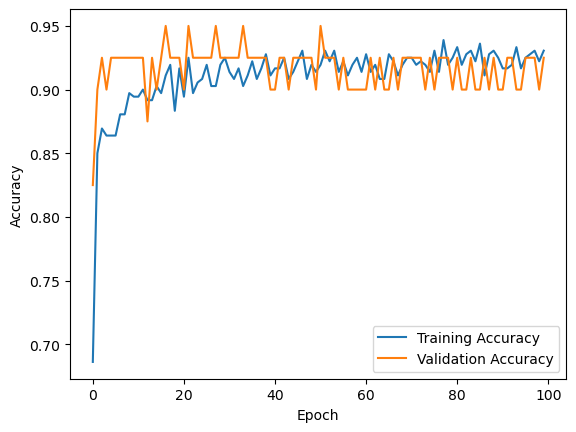

In [45]:
plt.plot(hist_model2.history['accuracy'], label='Training Accuracy')
plt.plot(hist_model2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

- This hyperparameter tuning didn't improve the model that much. 

#### **Model 3:**

In [46]:
backend.clear_session()

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [47]:
model3 = Sequential()
model3.add(Dense(256, activation='tanh', input_shape=(11,)))
model3.add(Dropout(0.1))
model3.add(Dense(128, activation='tanh'))
model3.add(Dropout(0.1))
model3.add(Dense(64, activation='tanh'))
model3.add(Dropout(0.1))
model3.add(Dense(32, activation='tanh'))
model3.add(Dense(1, activation='sigmoid'))

opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
model3.compile(loss='binary_crossentropy', optimizer=opt ,metrics=['accuracy'])
model3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,337 (181.00 KB)

 Trainable params: 46,337 (181.00 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
hist_model3 = model3.fit(x_train_scaled, y_train,
 validation_split=0.1, epochs=200, verbose=1)

Epoch 1/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6926 - loss: 0.6123 - val_accuracy: 0.9000 - val_loss: 0.3788
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8333 - loss: 0.3921 - val_accuracy: 0.9000 - val_loss: 0.3009
Epoch 3/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8461 - loss: 0.3479 - val_accuracy: 0.9000 - val_loss: 0.3055
Epoch 4/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8430 - loss: 0.3214 - val_accuracy: 0.9000 - val_loss: 0.2876
Epoch 5/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8454 - loss: 0.3161 - val_accuracy: 0.9000 - val_loss: 0.2748
Epoch 6/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8658 - loss: 0.3053 - val_accuracy: 0.9250 - val_loss: 0.2618
Epoch 7/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8700 - loss: 0.2798 - val_accuracy: 0.9250 - val_loss: 0.2472
Epoch 8/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8698 - loss: 0.2615 - val_accuracy: 0.9250 - 

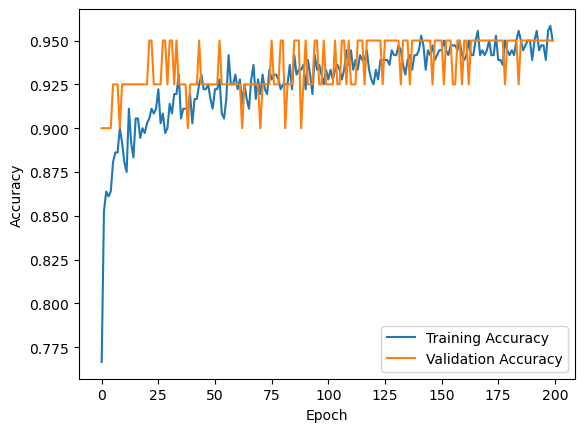

In [49]:
plt.plot(hist_model3.history['accuracy'], label='Training Accuracy')
plt.plot(hist_model3.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

- Both test and training accuracy imporved to ~95%. 

In [57]:
model3.evaluate(x_test_scaled, y_test, verbose=1)
y_pred = np.round(model3.predict(x_test_scaled))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9745 - loss: 0.0980 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


The test accuracy is 97% so the model was able to reproduce the performance on the unseen data and it generalize well. 

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        73
           1       0.90      1.00      0.95        27

    accuracy                           0.97       100
   macro avg       0.95      0.98      0.96       100
weighted avg       0.97      0.97      0.97       100



Text(70.72222222222221, 0.5, 'Actual')

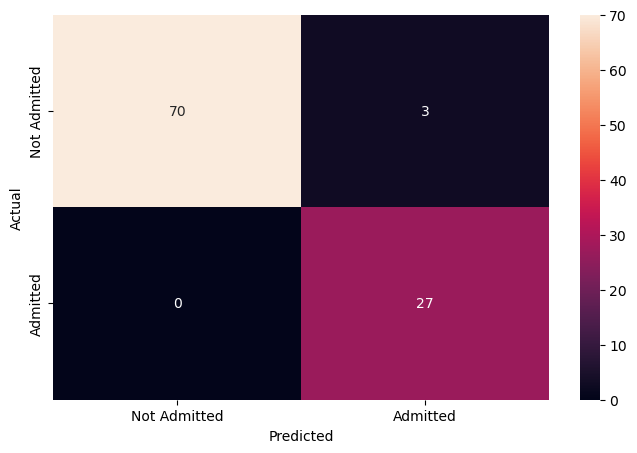

In [64]:
print(classification_report(y_test,y_pred))
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,5))
tick = ['Not Admitted', 'Admitted']
sns.heatmap(cm, annot=True, fmt='.0f', xticklabels=tick, yticklabels=tick )
plt.xlabel('Predicted')
plt.ylabel('Actual')

- The model has very high f1-score 95% and accuracy of 97%. 
- The model can predict all of the student that admitted to the UCLA and has a minor error in predicting few that will get to the school but in reality they failed to get admitted. 

Questing why we didn't use first drop option in get dummies?